# Football Match Outcome Prediction
Using Machine Learning to Predict European Soccer Match Results
**Dataset:** European Soccer Database (Kaggle)  
**Time Period:** 2008-2016  
**Matches:** 25,000+  
**Objective:** Predict Win/Draw/Loss outcomes using team attributes and betting odds

# Import Libraries and Setup


In [19]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import warnings
warnings.filterwarnings('ignore')

# Load Data from SQLite Database


In [11]:
# Database path
DB_PATH = r"..\data\database.sqlite"

def load_data(db_path):
    """Load all relevant tables from SQLite database"""
    conn = sqlite3.connect(db_path)
    
    # Load tables
    matches = pd.read_sql('SELECT * FROM "Match"', conn)
    teams = pd.read_sql('SELECT * FROM Team', conn)
    team_attributes = pd.read_sql('SELECT * FROM Team_Attributes', conn)
    
    conn.close()
    
    print(f"Successfully loaded:")
    print(f"   • {len(matches):,} matches")
    print(f"   • {len(teams):,} teams")
    print(f"   • {len(team_attributes):,} team attribute records")
    
    return matches, teams, team_attributes

# Load data
matches, teams, team_attributes = load_data(DB_PATH)

Successfully loaded:
   • 25,979 matches
   • 299 teams
   • 1,458 team attribute records


# Exploratory Data Analysis (EDA)

In [12]:
# Dataset overview
print("DATASET OVERVIEW")
print(f"\nDataset Shape: {matches.shape}")
print(f"   • Rows (Matches): {matches.shape[0]:,}")
print(f"   • Columns (Features): {matches.shape[1]}")

print("\nSample Data:")
matches.head()

DATASET OVERVIEW

Dataset Shape: (25979, 115)
   • Rows (Matches): 25,979
   • Columns (Features): 115

Sample Data:


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [13]:
# Check data types and missing values
print("DATA QUALITY CHECK")

# Analyze missing values
missing_data = matches.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

if len(missing_data) > 0:
    print(f"\nMissing Values Found in {len(missing_data)} columns")
    
    # Calculate missing percentage
    missing_df = pd.DataFrame({
        'Column': missing_data.index,
        'Missing_Count': missing_data.values,
        'Missing_Percentage': (missing_data.values / len(matches) * 100).round(2)
    })
    
    print(f"\nTop 15 Columns with Missing Values:")
    print(missing_df.head(15).to_string(index=False))
    
    print(f"\nMissing Data Summary:")
    print(f"   • Total missing values: {missing_data.sum():,}")
    print(f"   • Columns affected: {len(missing_data)}/{len(matches.columns)}")
    
    # Categorize columns by missing percentage
    high_missing = missing_df[missing_df['Missing_Percentage'] > 50]
    medium_missing = missing_df[(missing_df['Missing_Percentage'] > 20) & 
                                (missing_df['Missing_Percentage'] <= 50)]
    low_missing = missing_df[missing_df['Missing_Percentage'] <= 20]
    
    print(f"\nMissing Data Breakdown:")
    print(f"   • High missing (>50%): {len(high_missing)} columns")
    print(f"   • Medium missing (20-50%): {len(medium_missing)} columns")
    print(f"   • Low missing (<20%): {len(low_missing)} columns")
else:
    print("No missing values found!")

DATA QUALITY CHECK

Missing Values Found in 104 columns

Top 15 Columns with Missing Values:
 Column  Missing_Count  Missing_Percentage
    PSA          14811               57.01
    PSD          14811               57.01
    PSH          14811               57.01
    BSH          11818               45.49
    BSD          11818               45.49
    BSA          11818               45.49
    GBH          11817               45.49
    GBD          11817               45.49
    GBA          11817               45.49
   goal          11762               45.28
shotoff          11762               45.28
 corner          11762               45.28
  cross          11762               45.28
 shoton          11762               45.28
   card          11762               45.28

Missing Data Summary:
   • Total missing values: 407,395
   • Columns affected: 104/115

Missing Data Breakdown:
   • High missing (>50%): 3 columns
   • Medium missing (20-50%): 17 columns
   • Low missing (<20%): 84 

In [14]:
# Identify column types for smart handling
print("COLUMN CATEGORIZATION")

# Core match information 
core_columns = ['id', 'country_id', 'league_id', 'season', 'stage', 'date',
                'home_team_api_id', 'away_team_api_id', 
                'home_team_goal', 'away_team_goal', 'match_api_id']

# Betting odds columns 
betting_columns = [col for col in matches.columns if any(
    bookie in col for bookie in ['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 
                                  'VC', 'GB', 'BS']
)]

# Team and player columns
team_player_columns = [col for col in matches.columns if any(
    keyword in col for keyword in ['team', 'player', 'home', 'away']
)]

# Other match details
detail_columns = [col for col in matches.columns if col not in 
                 core_columns + betting_columns + team_player_columns]

print(f"\nColumn Categories:")
print(f"   • Core columns: {len(core_columns)}")
print(f"   • Betting odds: {len(betting_columns)}")
print(f"   • Team/Player: {len(team_player_columns)}")
print(f"   • Other details: {len(detail_columns)}")

COLUMN CATEGORIZATION

Column Categories:
   • Core columns: 11
   • Betting odds: 30
   • Team/Player: 70
   • Other details: 8


In [15]:
# Check betting odds availability
print("BETTING ODDS ANALYSIS")

# Main bookmakers to check
main_bookies = {
    'B365': ['B365H', 'B365D', 'B365A'],  # Bet365
    'BW': ['BWH', 'BWD', 'BWA'],          # Bet&Win
    'IW': ['IWH', 'IWD', 'IWA'],          # Interwetten
    'LB': ['LBH', 'LBD', 'LBA'],          # Ladbrokes
    'WH': ['WHH', 'WHD', 'WHA']           # William Hill
}

print("\nBetting Odds Availability:")
for bookie, cols in main_bookies.items():
    if all(col in matches.columns for col in cols):
        missing_pct = matches[cols].isnull().any(axis=1).sum() / len(matches) * 100
        available_pct = 100 - missing_pct
        print(f"   • {bookie:6s}: {available_pct:5.1f}% available")
    else:
        print(f"   • {bookie:6s}: Not in dataset")

BETTING ODDS ANALYSIS

Betting Odds Availability:
   • B365  :  87.0% available
   • BW    :  86.9% available
   • IW    :  86.7% available
   • LB    :  86.8% available
   • WH    :  86.9% available


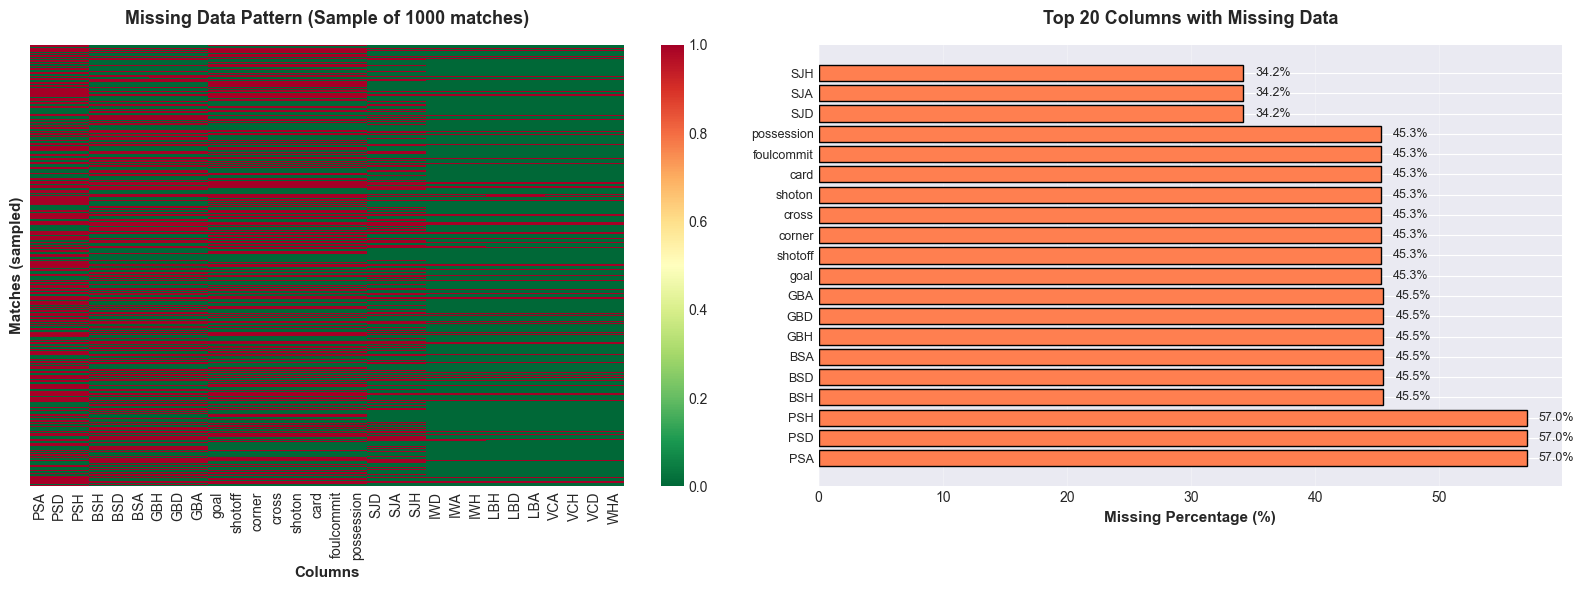

In [16]:
# Visualize missing data pattern

# Select columns for visualization (top 30 with most missing)
top_missing_cols = missing_data.head(30).index.tolist()
missing_matrix = matches[top_missing_cols].isnull()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Missing data heatmap
ax1 = axes[0]
# Sample 1000 rows for better visualization
sample_idx = np.random.choice(len(matches), min(1000, len(matches)), replace=False)
sns.heatmap(missing_matrix.iloc[sample_idx], 
            yticklabels=False, 
            cbar=True,
            cmap='RdYlGn_r',
            ax=ax1)
ax1.set_title('Missing Data Pattern (Sample of 1000 matches)', 
             fontsize=13, fontweight='bold', pad=15)
ax1.set_xlabel('Columns', fontsize=11, fontweight='bold')
ax1.set_ylabel('Matches (sampled)', fontsize=11, fontweight='bold')

# Plot 2: Missing percentage by column
ax2 = axes[1]
missing_pct = (missing_data.head(20) / len(matches) * 100)
bars = ax2.barh(range(len(missing_pct)), missing_pct, color='coral', 
                edgecolor='black', linewidth=1)
ax2.set_yticks(range(len(missing_pct)))
ax2.set_yticklabels(missing_pct.index, fontsize=9)
ax2.set_xlabel('Missing Percentage (%)', fontsize=11, fontweight='bold')
ax2.set_title('Top 20 Columns with Missing Data', 
             fontsize=13, fontweight='bold', pad=15)
ax2.grid(axis='x', alpha=0.3)

# Add percentage labels
for i, (bar, val) in enumerate(zip(bars, missing_pct)):
    width = bar.get_width()
    ax2.text(width + 1, bar.get_y() + bar.get_height()/2,
            f'{val:.1f}%', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('missing_data_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Clean the dataset - keep only essential columns
print("DATA CLEANING PROCESS")

# Select columns we actually need
essential_columns = [
    # Match identifiers
    'id', 'match_api_id', 'date', 'season', 'league_id',
    
    # Teams and results
    'home_team_api_id', 'away_team_api_id',
    'home_team_goal', 'away_team_goal',
    
    # Best available betting odds (Bet365)
    'B365H', 'B365D', 'B365A'
]

# Check which columns exist
available_essential = [col for col in essential_columns if col in matches.columns]
missing_essential = [col for col in essential_columns if col not in matches.columns]

print(f"\nAvailable essential columns: {len(available_essential)}/{len(essential_columns)}")
if missing_essential:
    print(f"Missing essential columns: {missing_essential}")

# Create clean dataset
matches_clean_base = matches[available_essential].copy()

print(f"\nDataset after selecting essential columns:")
print(f"   • Original shape: {matches.shape}")
print(f"   • New shape: {matches_clean_base.shape}")
print(f"   • Columns reduced: {matches.shape[1]} → {matches_clean_base.shape[1]}")

# Check missing values in essential columns
print(f"\nMissing values in essential columns:")
essential_missing = matches_clean_base.isnull().sum()
essential_missing = essential_missing[essential_missing > 0]

if len(essential_missing) > 0:
    for col, count in essential_missing.items():
        pct = (count / len(matches_clean_base)) * 100
        print(f"   • {col:20s}: {count:6,} ({pct:5.1f}%)")
else:
    print("No missing values in core match data!")

# Drop rows where core match data is missing
core_columns_check = ['home_team_api_id', 'away_team_api_id', 
                      'home_team_goal', 'away_team_goal']
matches_clean_base = matches_clean_base.dropna(subset=core_columns_check)

print(f"\nAfter dropping rows with missing core data:")
print(f"   • Remaining matches: {len(matches_clean_base):,}")
print(f"   • Data retention: {(len(matches_clean_base)/len(matches)*100):.1f}%")

DATA CLEANING PROCESS

Available essential columns: 12/12

Dataset after selecting essential columns:
   • Original shape: (25979, 115)
   • New shape: (25979, 12)
   • Columns reduced: 115 → 12

Missing values in essential columns:
   • B365H               :  3,387 ( 13.0%)
   • B365D               :  3,387 ( 13.0%)
   • B365A               :  3,387 ( 13.0%)

After dropping rows with missing core data:
   • Remaining matches: 25,979
   • Data retention: 100.0%


In [ ]:
# Key statistics (using cleaned base data)
print("KEY STATISTICS")

print("\nGoals Statistics:")
print(matches_clean_base[['home_team_goal', 'away_team_goal']].describe())

print("\nDate Range:")
matches_clean_base['date'] = pd.to_datetime(matches_clean_base['date'])
print(f"   • First match: {matches_clean_base['date'].min()}")
print(f"   • Last match: {matches_clean_base['date'].max()}")
print(f"   • Duration: {(matches_clean_base['date'].max() - matches_clean_base['date'].min()).days} days")

# Update matches variable for subsequent analysis
matches = matches_clean_base.copy()


KEY STATISTICS

Goals Statistics:
       home_team_goal  away_team_goal
count    25979.000000    25979.000000
mean         1.544594        1.160938
std          1.297158        1.142110
min          0.000000        0.000000
25%          1.000000        0.000000
50%          1.000000        1.000000
75%          2.000000        2.000000
max         10.000000        9.000000

Date Range:
   • First match: 2008-07-18 00:00:00
   • Last match: 2016-05-25 00:00:00
   • Duration: 2868 days


# Data Processing

Load dữ liệu từ SQLite

In [38]:
con = sqlite3.connect(DB_PATH)

# Query lấy dữ liệu Match và Odds
query = """
SELECT
    m.match_api_id,
    m.date,
    m.season,
    m.league_id,
    m.home_team_api_id,
    m.away_team_api_id,
    m.home_team_goal,
    m.away_team_goal,
    m.B365H, m.B365D, m.B365A,
    m.BWH, m.BWD, m.BWA
FROM Match m
WHERE m.home_team_goal IS NOT NULL 
  AND m.away_team_goal IS NOT NULL
  AND m.date IS NOT NULL
"""
df = pd.read_sql_query(query, con)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

print(f"Tổng số trận: {df.shape[0]}")
df.head(3)

Tổng số trận: 25979


,match_api_id,date,season,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,B365D,B365A,BWH,BWD,BWA
0,486263,2008-07-18,2008/2009,24558,10192,9931,1,2,NaN,NaN,NaN,NaN,NaN,NaN
1,486264,2008-07-19,2008/2009,24558,9930,10179,3,1,NaN,NaN,NaN,NaN,NaN,NaN
2,486265,2008-07-20,2008/2009,24558,10199,9824,1,2,NaN,NaN,NaN,NaN,NaN,NaN


Tạo nhãn kết quả (Target Label)

In [43]:
conditions = [
    df["home_team_goal"] > df["away_team_goal"],
    df["home_team_goal"] == df["away_team_goal"],
    df["home_team_goal"] < df["away_team_goal"]
]
choices = ["Win", "Draw", "Loss"]

df["result"] = np.select(conditions, choices, default="Unknown")

# Kiểm tra tỉ lệ nhãn
print(" Tỉ lệ các nhãn:")
# Dùng astype(str) để đảm bảo không lỗi format
print(df["result"].value_counts(normalize=True).map('{:.2%}'.format))

 Tỉ lệ các nhãn:
result
Win     45.87%
Loss    28.74%
Draw    25.39%
Name: proportion, dtype: object


Xử lý dữ liệu lịch sử (Team History)

In [51]:
def build_team_history(df_matches):
    # Home stats
    home = df_matches[["date", "match_api_id", "home_team_api_id", "home_team_goal", "away_team_goal"]].copy()
    home.columns = ["date", "match_api_id", "team_id", "goals_for", "goals_against"]
    home["is_home"] = 1
    
    # Away stats
    away = df_matches[["date", "match_api_id", "away_team_api_id", "away_team_goal", "home_team_goal"]].copy()
    away.columns = ["date", "match_api_id", "team_id", "goals_for", "goals_against"]
    away["is_home"] = 0
    
    team_df = pd.concat([home, away], ignore_index=True).sort_values(["team_id", "date"])
    
    # Tính điểm (3=Thắng, 1=Hòa, 0=Thua)
    team_df["points"] = np.where(team_df["goals_for"] > team_df["goals_against"], 3,
                                 np.where(team_df["goals_for"] == team_df["goals_against"], 1, 0))
    return team_df

team_df = build_team_history(df)
print(f"Bảng lịch sử với {team_df.shape[0]} dòng.")
team_df.head(3)

Bảng lịch sử với 51958 dòng.


,date,match_api_id,team_id,goals_for,goals_against,is_home,points
26026,2008-08-10,506542,1601,0,0,0,1
85,2008-08-16,506549,1601,2,1,1,3
107,2008-08-22,506557,1601,2,1,1,3


Tạo Feature phong độ (Rolling Window)


In [56]:
def add_rolling_features(team_df):
    team_df = team_df.copy()
    
    # Tính Goal Difference (GD) trước khi Groupby
    team_df["gd"] = team_df["goals_for"] - team_df["goals_against"]

    g = team_df.groupby("team_id", sort=False)
    
    # Tính trung bình 5 trận TRƯỚC ĐÓ (shift 1)
    # min_periods=1: Tính khi có 1 trận trở lên trong lịch sử
    team_df["last5_points"] = g["points"].transform(lambda s: s.shift(1).rolling(5, min_periods=1).mean())
    
    # Rolling trực tiếp trên cột 'gd'
    team_df["last5_gd"] = g["gd"].transform(lambda s: s.shift(1).rolling(5, min_periods=1).mean())
    
    return team_df

team_df = add_rolling_features(team_df)
team_df.head(3)

,date,match_api_id,team_id,goals_for,goals_against,is_home,points,last5_points,last5_gd,gd
26026,2008-08-10,506542,1601,0,0,0,1,NaN,NaN,0
85,2008-08-16,506549,1601,2,1,1,3,1.0,0.0,1
107,2008-08-22,506557,1601,2,1,1,3,2.0,0.5,1


Merge Features về lại bảng trận đấu

In [59]:
def merge_features(df_matches, team_df):
    cols = ["match_api_id", "team_id", "last5_points", "last5_gd"]
    
    # Lấy features cho Home Team
    home_feats = team_df[team_df["is_home"] == 1][cols].rename(columns={"team_id": "home_team_api_id"})
    home_feats = home_feats.add_prefix("home_")
    
    # Lấy features cho Away Team
    away_feats = team_df[team_df["is_home"] == 0][cols].rename(columns={"team_id": "away_team_api_id"})
    away_feats = away_feats.add_prefix("away_")
    
    # Merge
    out = df_matches.merge(home_feats, left_on=["match_api_id", "home_team_api_id"], right_on=["home_match_api_id", "home_home_team_api_id"], how="left")
    out = out.merge(away_feats, left_on=["match_api_id", "away_team_api_id"], right_on=["away_match_api_id", "away_away_team_api_id"], how="left")
    
    # Tính features chênh lệch (Diff)
    out["diff_last5_points"] = out["home_last5_points"] - out["away_last5_points"]
    out["diff_last5_gd"]     = out["home_last5_gd"] - out["away_last5_gd"]
    
    return out

df_final = merge_features(df, team_df)
df_final.head(-1)

,match_api_id,date,season,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,B365D,B365A,BWH,BWD,BWA,result,home_match_api_id,home_home_team_api_id,home_last5_points,home_last5_gd,away_match_api_id,away_away_team_api_id,away_last5_points,away_last5_gd,diff_last5_points,diff_last5_gd
0,486263,2008-07-18,2008/2009,24558,10192,9931,1,2,NaN,NaN,NaN,NaN,NaN,NaN,Loss,486263,10192,NaN,NaN,486263,9931,NaN,NaN,NaN,NaN
1,486264,2008-07-19,2008/2009,24558,9930,10179,3,1,NaN,NaN,NaN,NaN,NaN,NaN,Win,486264,9930,NaN,NaN,486264,10179,NaN,NaN,NaN,NaN
2,486265,2008-07-20,2008/2009,24558,10199,9824,1,2,NaN,NaN,NaN,NaN,NaN,NaN,Loss,486265,10199,NaN,NaN,486265,9824,NaN,NaN,NaN,NaN
3,486266,2008-07-20,2008/2009,24558,7955,10243,1,2,NaN,NaN,NaN,NaN,NaN,NaN,Loss,486266,7955,NaN,NaN,486266,10243,NaN,NaN,NaN,NaN
4,486268,2008-07-23,2008/2009,24558,6493,7955,1,2,NaN,NaN,NaN,NaN,NaN,NaN,Loss,486268,6493,NaN,NaN,486268,7955,0.0,-1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25973,1992221,2016-05-22,2015/2016,24558,9956,10191,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Draw,1992221,9956,1.2,-0.4,1992221,10191,1.2,0.2,0.0,-0.6
25974,1992225,2016-05-25,2015/2016,24558,9931,9956,0,1,NaN,NaN,NaN,NaN,NaN,NaN,Loss,1992225,9931,2.0,-0.2,1992225,9956,0.8,-0.8,1.2,0.6
25975,1992226,2016-05-25,2015/2016,24558,7896,10190,3,0,NaN,NaN,NaN,NaN,NaN,NaN,Win,1992226,7896,1.0,0.2,1992226,10190,0.8,-0.8,0.2,1.0
25976,1992227,2016-05-25,2015/2016,24558,10199,10179,2,2,NaN,NaN,NaN,NaN,NaN,NaN,Draw,1992227,10199,2.6,2.2,1992227,10179,1.0,-0.4,1.6,2.6


Split Train/Test và Pipeline làm sạch

In [61]:
# 1. Định nghĩa Features
TARGET = "result"
numeric_cols = ["diff_last5_points", "diff_last5_gd", "B365H", "B365D", "B365A", "BWH", "BWD", "BWA"]
cat_cols = ["league_id"]

# 2. Split theo thời gian
df_final["season_start"] = df_final["season"].apply(lambda x: int(x.split("/")[0]))
train_df = df_final[df_final["season_start"] <= 2014].copy()
test_df  = df_final[df_final["season_start"] >= 2015].copy()

X_train = train_df[numeric_cols + cat_cols]
y_train = train_df[TARGET]
X_test  = test_df[numeric_cols + cat_cols]
y_test  = test_df[TARGET]

# 3. Pipeline làm sạch & biến đổi
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Điền số thiếu bằng trung vị
    ('scaler', StandardScaler())                    # Chuẩn hóa về cùng tỉ lệ
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Điền missing bằng giá trị hay gặp
    ('onehot', OneHotEncoder(handle_unknown='ignore'))    # Mã hóa One-hot
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

# 4. Thực thi (Fit & Transform)
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

print(f"X_train shape: {X_train_proc.shape}")
print(f"X_test shape:  {X_test_proc.shape}")

# Kiểm tra NaN
try:
    n_nans = np.isnan(X_train_proc).sum()
except:
    n_nans = np.isnan(X_train_proc.toarray()).sum()
    
print(f"Số lượng giá trị lỗi (NaN) còn lại: {n_nans}")

X_train shape: (22653, 19)
X_test shape:  (3326, 19)
Số lượng giá trị lỗi (NaN) còn lại: 0
